## 1. 모델링

사전설정 (모델 훈련과 예측 모두 공통)

In [4]:
cols = ["KOSPI", "CR", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI"]
len_x_ARMA = 10
len_y_nextday = 20

1-1) 데이터 크롤링

In [ ]:
from kospi_predict import Crawler

crawler = Crawler(crawl_page_max=50, perPage=100)
df_crawled = crawler.crawlData(cols)
df_crawled

1-2. 데이터 전처리

In [ ]:
from kospi_predict import DataPreprocessor

dpp = DataPreprocessor(df_crawled, cols)
dpp.sortByDate()
dpp.scalingForModeling()
dpp.makeTargetXs(len_x_ARMA)
dpp.makeTargetYs(len_y_nextday)
dpp.cutoffData(len_x_ARMA, len_y_nextday)
dpp.splitData()
dpp.df_cutoff

1-3) 모델 훈련하고 생성

In [ ]:
from kospi_predict import ModelMaker

maker = ModelMaker(dpp.y_list, dpp.df_train, dpp.df_test)
maker.makeModel(EPOCHS=800, history_plot_cutoff=30, learning_rate=0.0008)
maker.validateModel(y_no=0)

## 2. 최근 데이터로 20일 간의 KOSPI 지수 예측

2-1) 데이터 수집

In [5]:
from kospi_predict import Crawler

#예측을 위해서는 현재기준 이전 10일간의 데이터만 있으면 됨 (len_x_ARMA가 10일때)
crawler_pred = Crawler(crawl_page_max=1, perPage=50) #이전 추세도 볼겸 넉넉히 수집
df_crawled_pred = crawler_pred.crawlData(cols)
df_crawled_pred


KOSPI : 1번째 페이지 데이터 수집중...
CR : 1번째 페이지 데이터 수집중...
NASDAQ : 1번째 페이지 데이터 수집중...
DOW : 1번째 페이지 데이터 수집중...
NIKKEI : 1번째 페이지 데이터 수집중...


,date,KOSPI,CR,NASDAQ,DOW,NIKKEI,SHANGHAI
0,2022-02-18,2744.52,1195.5,13548.066,34079.18,27122.07,286.366
1,2022-02-17,2744.09,1197.5,13716.719,34312.03,27232.87,284.743
2,2022-02-16,2729.68,1198.0,14124.095,34934.27,27460.40,284.624
3,2022-02-15,2676.54,1197.5,14139.757,34988.84,26865.19,283.019
4,2022-02-14,2704.48,1197.5,13790.919,34566.17,27079.59,283.258
5,2022-02-10,2771.93,1196.5,14185.641,35241.59,27696.08,285.679
6,2022-02-09,2768.85,1196.0,14490.373,35768.06,27579.87,285.237
7,2022-02-08,2746.47,1198.5,14194.455,35462.78,27284.52,282.772
8,2022-02-07,2745.06,1200.5,14015.668,35091.13,27248.87,282.482
9,2022-01-28,2663.34,1211.5,13770.573,34725.47,26717.34,280.726


2-2) 데이터 전처리

In [6]:
from kospi_predict import DataPreprocessor

#아래는 예측을 위한 전처리
dpp_pred = DataPreprocessor(df_crawled_pred, cols)
dpp_pred.sortByDate()
dpp_pred.scalingForPredict()
dpp_pred.makeTargetXs(len_x_ARMA)
dpp_pred.cutoffData(len_x_ARMA, 0)

2-3) 예측

2022-02-21 17:04:39.257400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


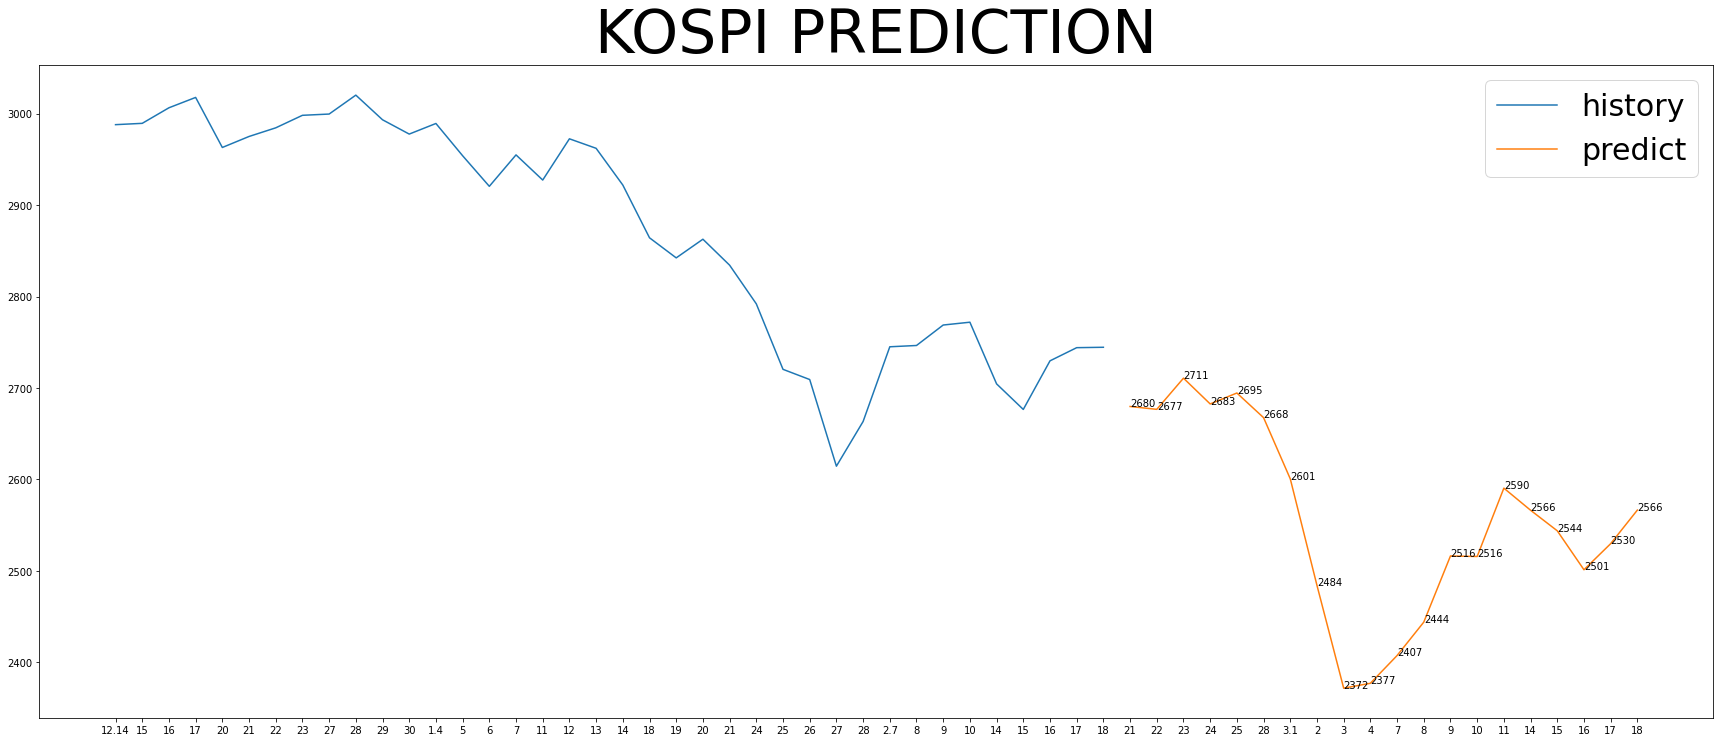

In [10]:
from kospi_predict import Predictor

#2.18 기준으로 20일 뒤까지 예측하고 시각화

predictor = Predictor(dpp_pred.df)
predictor.predict()
predictor.showPredictionPlot()
# predictor.saveModelToJS()